# System Setup

In [1]:
import sys
%matplotlib inline
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install GPy
# !{sys.executable} -m pip install seaborn

In [2]:
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

# Data Wrangling

In [3]:
class AllData:
    """Load the data from the set path and prepare it in a useable format. 
    """
    def __init__(self):
        self.folder_name = "/bns_m3_3comp" # Change folder name of data as required. 
    
    def load_path(self, path_to_dir):
        """ User defined path
        """
        self.folder_path = path_to_dir
        self.path = path_to_dir + self.folder_name
        return None
    
    def load_raw_data(self):
        """ Loads raw data from given path. Implimentation may different for windows and mac/linux users.
        >>> data = AllData()
        >>> data.load_path("/Users/utkarsh/PycharmProjects/SURP2021")
        >>> data.load_raw_data()
        >>> print(data.raw_data.file_name.iloc[0])
        nph1.0e+06_mejdyn0.001_mejwind0.130_phi45.txt
        >>> data.raw_data.file_name.iloc[192] == "nph1.0e+06_mejdyn0.001_mejwind0.090_phi0.txt"
        True
        >>> data.raw_data.file_name.iloc[192] == "nph1.0e+06_mejdyn0.005_mejwind0.110_phi0.txt"
        False
        >>> data.raw_data.file_name.iloc[192] == "nph1.0e+06_mejdyn0.005_mejwind0.110_phi0.txt"
        False
        """
        resd = defaultdict(list)
        folder_path = Path(self.path)
        for file in folder_path.iterdir():
            with open(file, "r") as file_open:
                resd["file_name"].append(file.name)
        temp_df = pd.DataFrame(resd)
        self.raw_data = temp_df[temp_df.file_name != ".DS_Store"].reset_index(drop=True)
        return None
        
        
    def process(self):
        """ Processes the data to a readable reference dataframe.
        >>> data = AllData()
        >>> data.load_path("/Users/utkarsh/PycharmProjects/SURP2021")
        >>> data.load_raw_data()
        >>> data.process()
        >>> print(data.reference_data.mejwind.iloc[68])
        0.03
        >>> print(data.reference_data.mejdyn.iloc[173])
        0.02
        >>> data.reference_data.phi.iloc[55] == 75
        False
        >>> data.reference_data.phi.iloc[57] == 75
        False
        >>> data.reference_data.phi.iloc[56] == 75
        True
        """
        split_series = self.raw_data.file_name.apply(lambda x: x.split('_'))
        temp_df = split_series.apply(pd.Series)
        temp_df["file_name"] = self.raw_data.file_name
        temp_df.columns = ["nph", "mejdyn", "mejwind", "phi", "filename"]
        temp_df["mejdyn"] = temp_df["mejdyn"].str.extract("(\d*\.?\d+)", expand=True)
        temp_df["mejwind"] = temp_df["mejwind"].str.extract("(\d*\.?\d+)", expand=True)
        temp_df["phi"] = temp_df["phi"].str.extract("(\d*\.?\d+)", expand=True)
        temp_df["nph"] = temp_df["nph"].apply(lambda x: float(x[3:]))
        temp_df[["mejdyn", "mejwind", "phi"]] = temp_df[["mejdyn", "mejwind", "phi"]].apply(pd.to_numeric)
        self.reference_data = temp_df.reset_index(drop=True)
        return None        
    
    def save_reference(self):
        """ Saves the reference data into a file for future use. 
        """
        try:
            self.reference_data.to_csv("reference.csv", index = False)
            print("[STATUS] Reference Saved")
        except Exception:
            print("[ERROR] Reference Unsaved")
    
    def load_reference(self, name):
        """ Loads the saved dataframe to save on computing time.
        >>> data = AllData()
        >>> data.load_reference("reference.csv")
        >>> print(data.reference_data.mejwind.iloc[68])
        0.03
        >>> print(data.reference_data.mejdyn.iloc[173])
        0.02
        >>> data.reference_data.phi.iloc[55] == 75
        False
        >>> data.reference_data.phi.iloc[57] == 75
        False
        >>> data.reference_data.phi.iloc[56] == 75
        True
        """
        self.reference_data = pd.read_csv(name)
        
            

# Light Curve Selection

In [4]:
class LightCurve():
    """ The information regarding KNe light curves and data corresponding to KNe light curves.
    """
    
    def __init__(self, referenceName):
        """ Initializes class, reference is all the light curves, and selected represents ones of interest to be narrowed. 
        """
        self.reference = pd.read_csv(referenceName)
        self.selected = self.reference.copy()

    def _slice(self, typ, Min, Max):
        sliced = self.selected[self.selected[typ] >= Min]
        sliced2 = sliced[sliced[typ] <= Max]
        return sliced2 
    
    def select_curve(self, phiRange, mejdynRange, mejwindRange, nphRange = [1e6]):
        """ Select a measurment based on the physics limits required. 
        >>> data = LightCurve("reference.csv")
        >>> phi_range = [30]
        >>> mejdyn_range = [0.01]
        >>> mejwind_range = [0.11]
        >>> data.select_curve(phiRange = phi_range, mejdynRange = mejdyn_range, mejwindRange = mejwind_range)
        >>> print(data.selected.filename.iloc[0])
        nph1.0e+06_mejdyn0.010_mejwind0.110_phi30.txt
        """
        self.selected = self._slice("nph", min(nphRange), max(nphRange))
        self.selected = self._slice("phi", min(phiRange), max(phiRange))
        self.selected = self._slice("mejdyn", min(mejdynRange), max(mejdynRange))   
        self.selected = self._slice("mejwind", min(mejwindRange), max(mejwindRange))   
        return None
    
    def _set_path(self):
        """ Sets the path to the file to be extracted. Chooses first file if there are many. 
        """
        self.folder_path = os.getcwd() + "/bns_m3_3comp/"
        self.path = self.folder_path + self.selected.filename.iloc[0]
        if len(self.selected.filename) > 1:
            print(f"[WARNING] Many curves in data: First curve has been selected. \n[CURVE] {self.selected.filename.iloc[0]}")
        
        return None
    
    def extract_curve(self):
        """ Extracts curve based on selected data and converts it into a readable format. 
        >>> data = LightCurve("reference.csv")
        >>> phi_range = [60]
        >>> mejdyn_range = [0.02]
        >>> mejwind_range = [0.11]
        >>> data.select_curve(phiRange = phi_range, mejdynRange = mejdyn_range, mejwindRange = mejwind_range)
        >>> data.extract_curve()
        >>> data.curve.shape
        (11, 500)
        >>> zBand = 910
        >>> plotDf = data.curve.loc[:, [zBand]]
        >>> print(plotDf.loc[1,zBand][3])
        0.0028678
        >>> print(data.selected.filename.iloc[0])
        nph1.0e+06_mejdyn0.020_mejwind0.110_phi60.txt
        """
        # Obtain path to read curve from. 
        self._set_path()
        
        # Read txt file containig light curve information
        temp0 = pd.read_csv(self.path, header = None, names = ["data"])
        
        # Set parameters for viewing angles, numbers of wavelengths, and time step. 
        self.Nobs = int(temp0.data.iloc[0])
        self.Nwave = float(temp0.data.iloc[1])
        self.Ntime = list(map(float, temp0.data.iloc[2].split()))
        
        # Drop information header and reset index. 
        temp1 = temp0.iloc[3:].reset_index(drop = True)
        
        # Convert data from string to float
        temp1["data"] = temp1["data"].apply(lambda x: list(map(float, x.split())))
        
        # Obtain wavelength from messy data list. Convert to nm
        temp1.loc[:, 'wavelength'] = temp1.data.map(lambda x: x[0]/10)
        
        # Remove wavelengths from data vector. 
        temp1["data"] = temp1["data"].apply(lambda x: x[1:])
        
        # Pivot to order the table by wavelengths
        temp1 = temp1.pivot(columns = "wavelength", values = "data")
        
        # Concatenate all rows to remove NA values to get a neat, readable dataframe. 
        final = pd.concat([temp1[col].dropna().reset_index(drop=True) for col in temp1], axis=1)
        
        # Rename axis titles. 
        final.index.name = "iobs"
        final.columns.name = "wavelength"
        self.curve = final
        
        return None
    
    def _odd(self,x):
        """Rounds to nearest odd numbers
        >>> data = LightCurve("reference.csv")
        >>> data._odd(3)
        3
        >>> data._odd(2.5)
        3
        >>> data._odd(2)
        3
        >>> data._odd(1.999)
        1
        """
        return 2 * int(x/2) + 1
    
    def simple_plot(self, wv):
        print("[STATUS] Plotting...")
        self.time_arr = np.linspace(int(self.Ntime[1]), int(self.Ntime[2]), int(self.Ntime[0]), endpoint = True)
        self.wavelength = 10*self._odd(wv/10)

        viewing_angles = np.linspace(0, 1, self.Nobs, endpoint = True)
        plt.figure(dpi = 300)
        plt.gca().set_prop_cycle("color", sns.color_palette("coolwarm_r",self.Nobs))
        for i,j in self.curve.loc[:, [self.wavelength]].iterrows():
            ang = round(np.degrees(np.arccos(viewing_angles[i])), 2) 
            plt.plot(self.time_arr, j.values[0], label = f"{ang}"r"$^o$", linewidth = 1)
        plt.xlabel("Time (Days)")
        plt.ylabel(r"Flux $Erg s^{-1} cm^{-2}A^{-1}$")
        plt.title(f"Lights curves for {self.Nobs} viewing angles at {self.wavelength}nm")
        utkarshGrid()
        plt.legend(title = r"$\Phi$")
        return None
    
    def plot_viewingangle_simple(self):
        self.uBand = 365 
        self.bBand = 445
        self.gBand = 464
        self.vBand = 551
        self.rBand = 658
        self.iBand = 806
        self.zBand = 900
        self.yBand = 1020
        self.jBand = 1220
        self.hBand = 1630
        self.kBand = 2190
        self.lBand = 3450
        self.mBand = 4750
        self.nBand = 10500
        self.qBand = 21000

        wvList = [self.uBand, self.gBand, self.rBand, self.iBand, 
                  self.zBand, self.yBand, self.jBand, self.hBand]

        plt.figure(dpi=300)
        print("[STATUS] Plotting...")
        for k in range(len(wvList)):
            wv = wvList[k]
            self.time_arr = np.linspace(int(self.Ntime[1]), int(self.Ntime[2]), int(self.Ntime[0]), endpoint = True)
            self.wavelength = 10*self._odd(wv/10)
            viewing_angles = np.linspace(0, 1, self.Nobs, endpoint = True)
            colors = sns.color_palette("coolwarm_r",len(wvList))[::-1]
            # plt.gca().set_prop_cycle("color", sns.color_palette("coolwarm_r",len(wvList)))

            for i,j in self.curve.loc[:, [self.wavelength]].iterrows():
                if i == 0:
                    labelStr = f"{self.wavelength}nm"
                else:
                    labelStr = f""
                ang = round(np.degrees(np.arccos(viewing_angles[i])), 2) 
                plt.plot(self.time_arr, j.values[0], label = labelStr, 
                         linewidth = 1, color = colors[k])

        plt.xlabel("Time (Days)")
        plt.ylabel(r"Log Flux $Erg s^{-1} cm^{-2}A^{-1}$")
        plt.legend(title = r"$\lambda$", ncol=2, loc = "upper right")
        plt.yscale("log")
        plt.title(f"Lights curves for {self.Nobs} viewing angles at varying wavelengths")
        return None
    
    def plot_viewingangle(self): 
        warnings.filterwarnings( action='ignore', module='matplotlib.figure', category=UserWarning, 
                                message=('This figure includes Axes that are not compatible with tight_layout, '
             'so results might be incorrect.'))
        fig, axes = plt.subplots(nrows = 2, ncols = 4, dpi=300, figsize = (6,3.5))
        plt.tight_layout()
        self.time_arr = np.linspace(int(self.Ntime[1]), int(self.Ntime[2]), int(self.Ntime[0]), endpoint = True)
        viewing_angles = np.linspace(0, 1, self.Nobs, endpoint = True)
        colors = plt.cm.RdBu(np.linspace(-1,1,self.Nobs))
        counter = 0
        wvList = [self.uBand, self.gBand, self.rBand, self.iBand, 
                  self.zBand, self.yBand, self.jBand, self.hBand]
        namesList = ["uBand", "gBand", "rBand", "iBand", "zBand", "yBand", "jBand", "hBand"]
        ticks = np.arange(min(self.time_arr), max(self.time_arr)+1, 5)

        for row in range(0, 2):
            for col in range(0,4):
                wv = wvList[counter]
                self.wavelength = 10*self._odd(wv/10)

                for i,j in self.curve.loc[:, [self.wavelength]].iterrows():
                    if i == 0:

                        labelStr = f"{namesList[counter][0].upper()}"
                    else:
                        labelStr = f""
                    ang = round(np.degrees(np.arccos(viewing_angles[i])), 2) 
                    im = axes[row,col].plot(self.time_arr, j.values[0], label = labelStr, 
                             linewidth = 1, color = colors[i])

                axes[row,col].set_yscale('log')
                axes[row,col].legend(handletextpad=-2.0, handlelength=0)
                axes[row,col].axes.get_yaxis().set_visible(False)
                axes[row,col].set_xticks(ticks)

                counter += 1

        bottom, top = 0.1, 0.9
        left, right = 0.2, 0.8

        fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.15, wspace=0.25)
        my_cmap = "RdBu"
        sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=90))
        cbar_ax = fig.add_axes([1, bottom, 0.03, top-bottom])
        cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), extend='both', cax = cbar_ax)
        cbar.set_label(r"Viewing Angle $\theta_0$", size=15, labelpad=10)
        fig.text(0.5, 0, "Time since merger (Days)", ha='center')
        fig.text(-0.01, 0.5, r"Log Flux $Erg s^{-1} cm^{-2}A^{-1}$", va='center', rotation='vertical')
        return None
    
    def plot_mejdyn():
        pass
    
    def plot_mejwind():
        pass
    
    def plot_phi():
        pass   
        

# Script

In [5]:
# if __name__ == "__main__":
import doctest
doctest.testmod()

TestResults(failed=0, attempted=45)

In [6]:
# Parse Data
initial = AllData()

# Only needs to be done the first time
initial.load_path("/Users/utkarsh/PycharmProjects/SURP2021")
initial.load_raw_data()
initial.process()
initial.save_reference()
initial.reference_data


[STATUS] Reference Saved


,nph,mejdyn,mejwind,phi,filename
0,1000000.0,0.001,0.13,45,nph1.0e+06_mejdyn0.001_mejwind0.130_phi45.txt
1,1000000.0,0.010,0.05,15,nph1.0e+06_mejdyn0.010_mejwind0.050_phi15.txt
2,1000000.0,0.001,0.01,75,nph1.0e+06_mejdyn0.001_mejwind0.010_phi75.txt
3,1000000.0,0.005,0.09,75,nph1.0e+06_mejdyn0.005_mejwind0.090_phi75.txt
4,1000000.0,0.020,0.11,60,nph1.0e+06_mejdyn0.020_mejwind0.110_phi60.txt
...,...,...,...,...,...
191,1000000.0,0.005,0.11,0,nph1.0e+06_mejdyn0.005_mejwind0.110_phi0.txt
192,1000000.0,0.001,0.09,0,nph1.0e+06_mejdyn0.001_mejwind0.090_phi0.txt
193,1000000.0,0.020,0.07,0,nph1.0e+06_mejdyn0.020_mejwind0.070_phi0.txt
194,1000000.0,0.010,0.05,30,nph1.0e+06_mejdyn0.010_mejwind0.050_phi30.txt


In [7]:
# Selecting a singular light curve

data = LightCurve("reference.csv")
phi_range = [30,60]
mejdyn_range = [0.01, 0.02]
mejwind_range = [0.11]
data.select_curve(phiRange = phi_range, 
                  mejdynRange = mejdyn_range, 
                  mejwindRange = mejwind_range)
data.selected

,nph,mejdyn,mejwind,phi,filename
4,1000000.0,0.02,0.11,60,nph1.0e+06_mejdyn0.020_mejwind0.110_phi60.txt
88,1000000.0,0.01,0.11,60,nph1.0e+06_mejdyn0.010_mejwind0.110_phi60.txt
106,1000000.0,0.01,0.11,45,nph1.0e+06_mejdyn0.010_mejwind0.110_phi45.txt
123,1000000.0,0.02,0.11,30,nph1.0e+06_mejdyn0.020_mejwind0.110_phi30.txt
159,1000000.0,0.01,0.11,30,nph1.0e+06_mejdyn0.010_mejwind0.110_phi30.txt
186,1000000.0,0.02,0.11,45,nph1.0e+06_mejdyn0.020_mejwind0.110_phi45.txt


In [8]:
data.extract_curve()
data.curve.head(2) # iobs goes from 0 --> 10 (11 rows)

[WARNING] Many curves in data: First curve has been selected. 
[CURVE] nph1.0e+06_mejdyn0.020_mejwind0.110_phi60.txt


wavelength,10.0,30.0,50.0,70.0,90.0,110.0,130.0,150.0,170.0,190.0,...,9810.0,9830.0,9850.0,9870.0,9890.0,9910.0,9930.0,9950.0,9970.0,9990.0
iobs,,,,,,,,,,,,,,,,,,,,,
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.0387e-15, 1.2203e-06, 2.4324e-07, 7.9271e-0...","[1.4257e-12, 3.9016e-05, 1.2179e-05, 3.1122e-0...","[3.2954e-10, 0.00017416, 0.00010168, 3.2372e-0...","[3.4215e-08, 0.0027166, 0.00045816, 0.00013985...","[1.2376e-06, 0.00091114, 0.00071721, 0.0004897...","[2.0326e-05, 0.0029708, 0.0013356, 0.0011571, ...","[8.5044e-05, 0.0047244, 0.0021553, 0.0011496, ...","[0.00015567, 0.0015238, 0.0059957, 0.0013954, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.4802e-08, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 2.9992e-08, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8119e-08...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 3.1167e-08, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 3.827e-05, 0.0, 0.0,..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.9736e-15, 1.3601e-06, 2.3303e-07, 8.1683e-0...","[2.43e-12, 3.9696e-05, 1.2017e-05, 3.0895e-06,...","[5.3195e-10, 0.00017769, 0.00010233, 3.2907e-0...","[5.1259e-08, 0.0027128, 0.00046453, 0.00014821...","[1.769e-06, 0.00090998, 0.00073516, 0.00041236...","[2.2727e-05, 0.0030483, 0.0013946, 0.0011474, ...","[8.6299e-05, 0.0048463, 0.0020631, 0.0011407, ...","[0.00014803, 0.0015737, 0.0059852, 0.0017754, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.2769e-08, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 4.4778e-05, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 2.8966e-08, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7845e-08...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 3.1445e-08, 0.0, 0.0, 0.0, 0.0..."


[STATUS] Plotting...


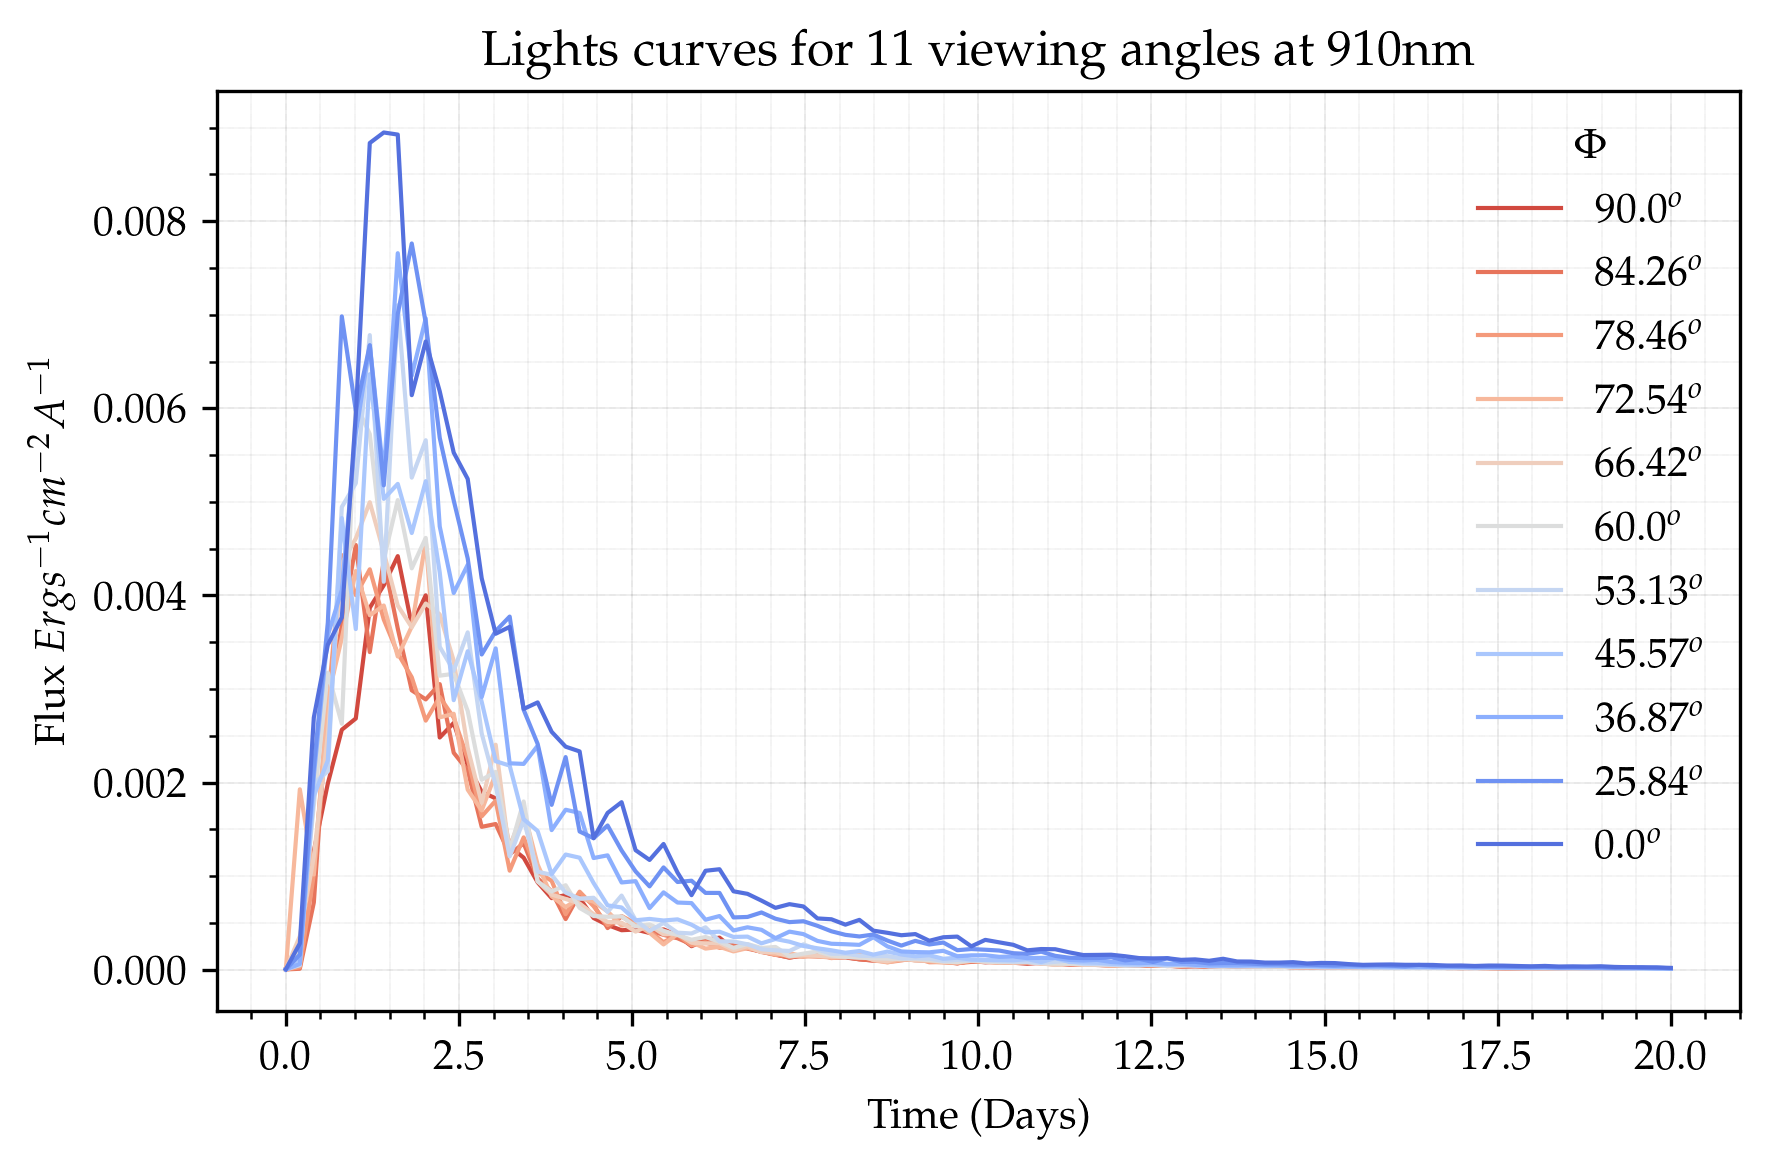

In [9]:
zBand = 900.0
data.simple_plot(zBand)

Plot is based on viewing angle. The plot is also general for any wavelength. 

[STATUS] Plotting...


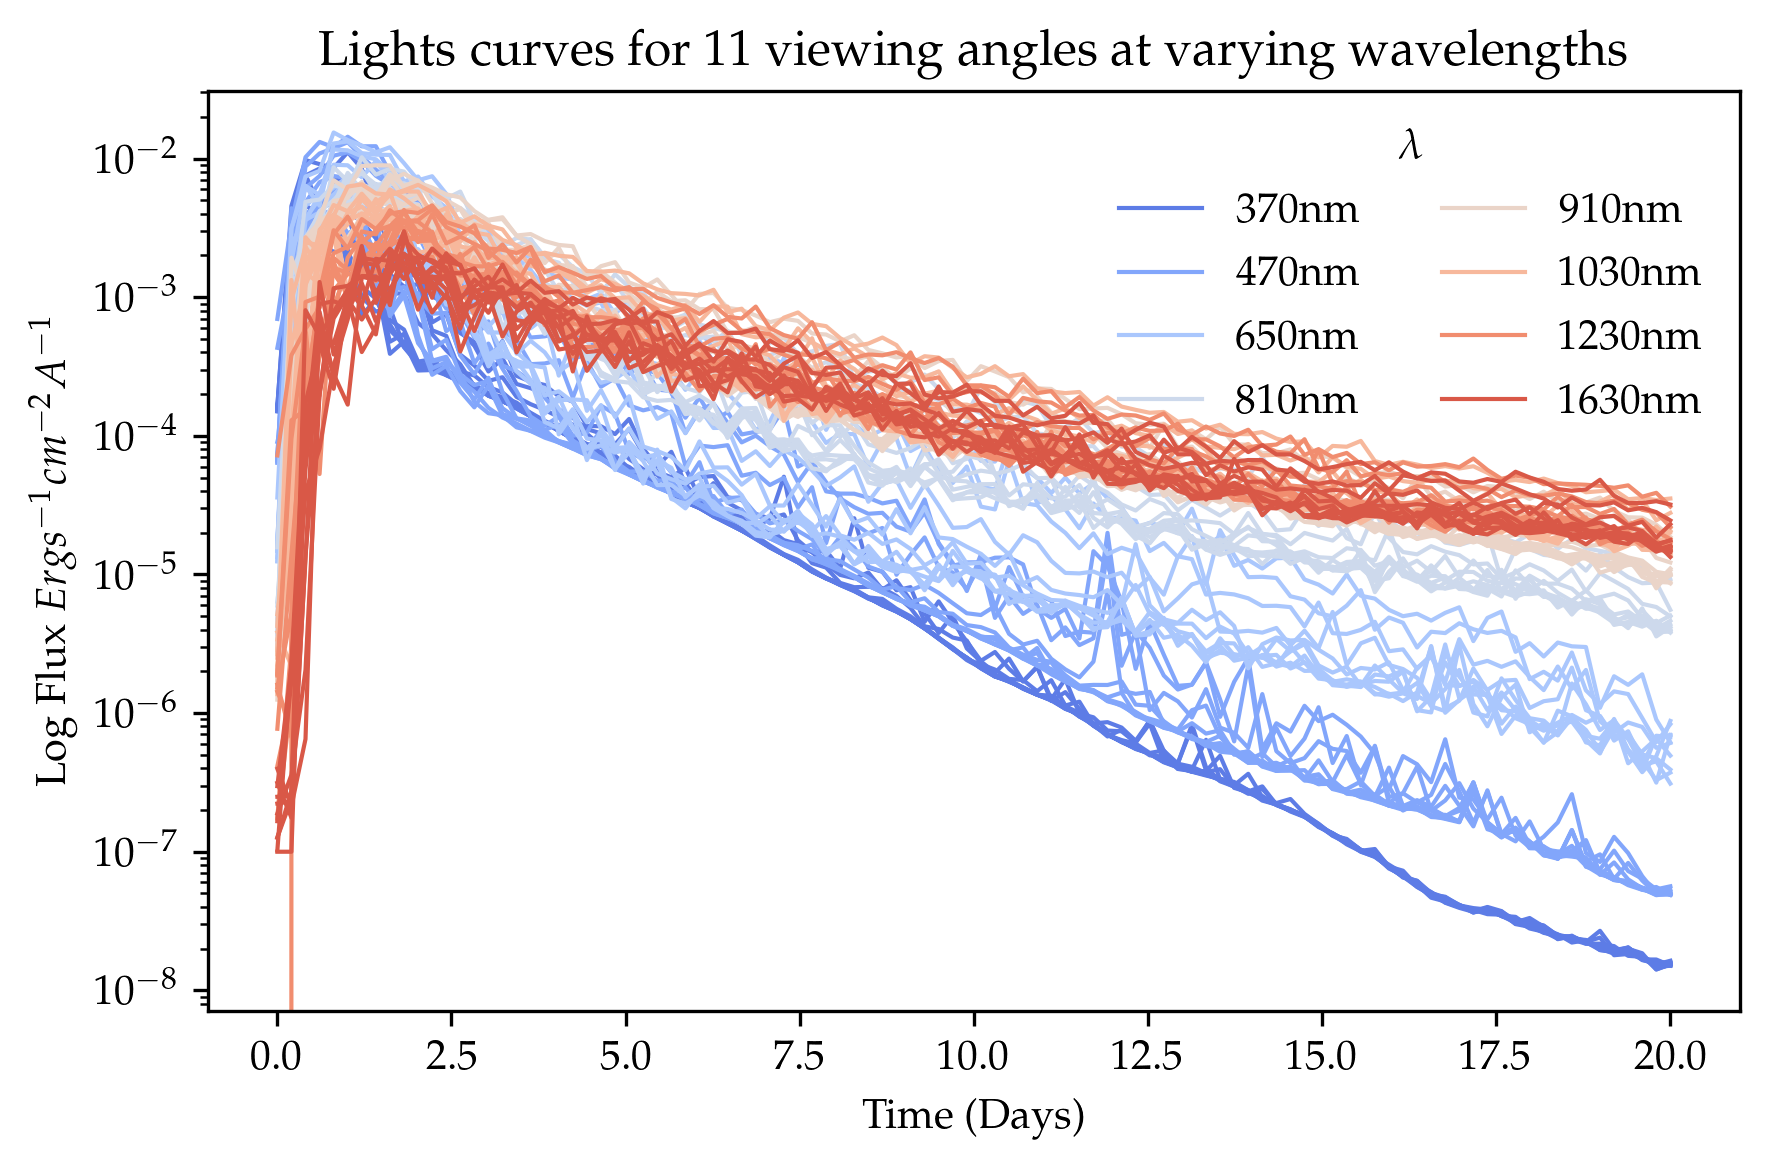

In [10]:
data.plot_viewingangle_simple()

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


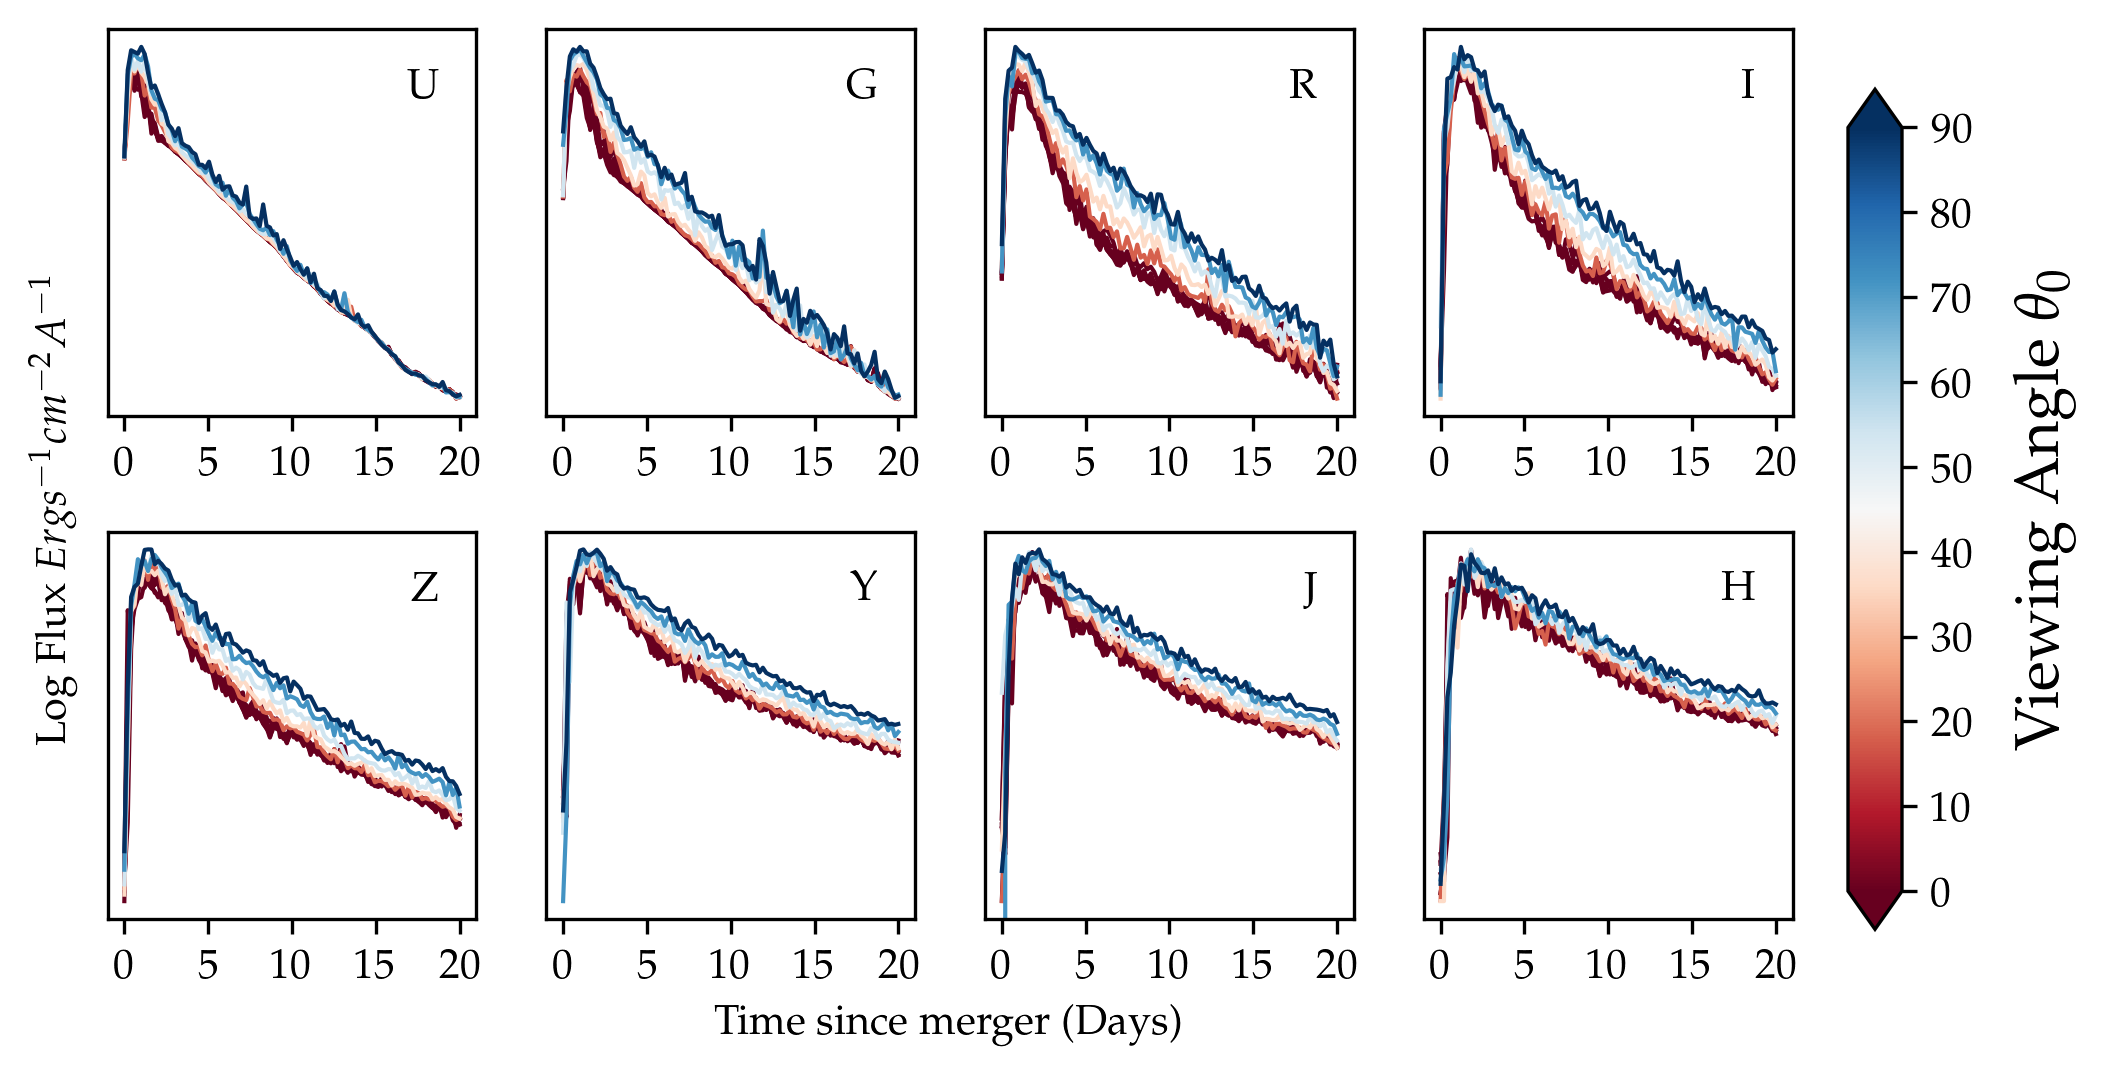

In [11]:
data.plot_viewingangle()

# Gaussian Process



In [ ]:
class GP:
    """The Gaussian Process for KNe Light Curves using GPy. 
    """
    
    def __init__(self):
        pass
    
    def range_select(self):
        pass

    def _normedDF(self):
        pass
    
    def _normedArr(self):
        pass
    
    def set_kernel(self):
        pass
    
    def set_model(self):
        pass
    
    def model_train(self):
        pass
    
    def plot_covariance(self):
        pass
    
    def plot_prior(self):
        pass
    
    def plot_posterior(self):
        pass
    

In [12]:
gp = LightCurve("reference.csv")
phi_range = [45]
mejdyn_range = [0.01]
mejwind_range = [0.11]
gp.select_curve(phiRange = phi_range, 
                  mejdynRange = mejdyn_range, 
                  mejwindRange = mejwind_range)
gp.extract_curve()
z = gp.curve.T[gp.curve.T.index == 910]
z = z.reset_index(drop = True)
z = z.apply(pd.Series.explode).reset_index(drop = True)
time_arr = np.linspace(gp.Ntime[1], gp.Ntime[2], int(gp.Ntime[0]), endpoint = True)
z["time"] = time_arr
z.index.name = "time_step"
print(z.shape)
z # THIS SHOULD GO INTO THE KNE Class

(100, 12)


iobs,0,1,2,3,4,5,6,7,8,9,10,time
time_step,,,,,,,,,,,,
0,0.000008,0.000075,0.000068,0.000074,0.000002,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,0.000000
1,0.000821,0.000162,0.0002,0.00032,0.000109,0.000424,0.000436,0.00078,0.000874,0.002856,0.000297,0.202020
2,0.001215,0.000896,0.0011,0.001182,0.001163,0.000646,0.001896,0.001691,0.002209,0.001234,0.00303,0.404040
3,0.002716,0.002916,0.001421,0.001165,0.002129,0.003567,0.003088,0.003888,0.005563,0.004848,0.004608,0.606061
4,0.001977,0.002169,0.001102,0.002042,0.003423,0.002785,0.00437,0.005405,0.00737,0.005397,0.003681,0.808081
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000024,0.000023,0.000023,0.000023,0.000022,0.000023,0.000024,0.000027,0.000025,0.000027,0.00003,19.191919
96,0.000018,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000021,0.000025,0.000028,0.000025,19.393939
97,0.000016,0.000014,0.000015,0.000014,0.000016,0.000018,0.000021,0.000023,0.000022,0.000022,0.000023,19.595960


In [13]:
# Q5
# Get time closest to one day. 
time_ind = np.argmin(np.abs(time_arr-1)) # Not sure what to do with "one day"

delta = 0
one_day = z.iloc[time_ind - delta: time_ind + delta + 1] # select around one day
del one_day["time"] # dont need time after choosing our time frame
one_day

iobs,0,1,2,3,4,5,6,7,8,9,10
time_step,,,,,,,,,,,
5,0.002709,0.002237,0.003472,0.003301,0.004151,0.005073,0.004041,0.005399,0.005223,0.005627,0.007347


In [14]:
# Q6, Q7
# Median normalization
def med_norm(df):
    med = np.median(df)
    return df.divide(med) - 1

def med_norm_arr(arr):
    med = np.median(arr)
    return arr/med - 1

normed = med_norm(one_day)
normed

iobs,0,1,2,3,4,5,6,7,8,9,10
time_step,,,,,,,,,,,
5,-0.347282,-0.46114,-0.163462,-0.204852,0.0,0.222102,-0.02638,0.300713,0.258215,0.35557,0.770141


In [15]:
# Q8, Q9
X = np.arange(0, gp.Nobs, 1)
Y = np.array(normed.iloc[0])
X = X.reshape(len(X), 1)
Y = Y.reshape(len(Y), 1)
kernel = GPy.kern.RBF(input_dim=1, variance = 2, lengthscale=2) # Variance
m = GPy.models.GPRegression(X, Y, kernel)

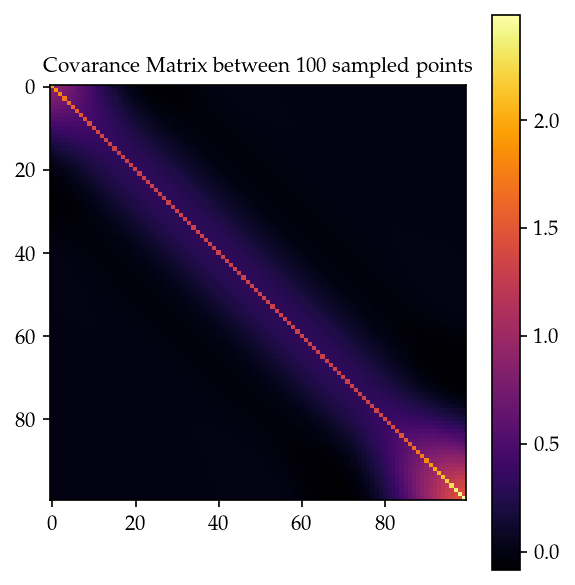

In [16]:
# Q10
predX = np.linspace(-1,12,100).reshape(100, 1)
predY_mean, predY_cov = m.predict(predX,  full_cov=True)

plt.figure(figsize = (4,4), dpi = 150)
plt.imshow(predY_cov, cmap = "inferno")
plt.colorbar()
plt.title(f"Covarance Matrix between {len(predY_cov)} sampled points", fontsize = 10)
plt.show()

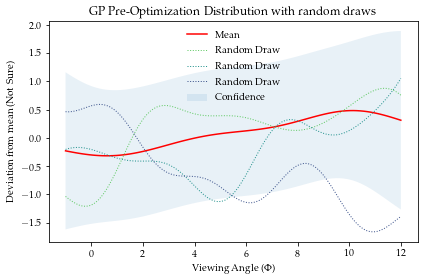

In [17]:
# I DID NOT USE THIS METHOD
# Multidmensional version of scipy normal
# Inject predY_var
# Random Draw from normal
# mu = 0
# sigma = 1
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# plt.plot(x, stats.norm.pdf(x, mu, sigma), label = "Unit Gaussian")


def custom_plot(predX, before = True):
    # Custom Plotting Function
    posteriorPredY = m.posterior_samples_f(predX, full_cov=True, size=3)
    predY, predY_cov = m.predict(predX, full_cov = True)
    var = np.diag(predY_cov)
    plotX = predX.reshape(1, len(predX))[0]
    plotY = predY.reshape(1, len(predY))[0]

    plt.figure()
    n = 1
    numVar = n * np.sqrt(var)
    
    # NOT SURE IF IT PLOTS CONFIDENCE APPROPRIATELY
    plt.fill_between(plotX, plotY + numVar, plotY - numVar, alpha = 0.1, label = "Confidence")
    plt.plot(plotX, plotY, label = "Mean", color = "Red")
    
    nRandomDraws = 3
    colors = sns.color_palette("viridis",nRandomDraws)[::-1]
    for i in range(len(colors)):     
        plt.plot(predX, posteriorPredY[:,0, i], label= "Random Draw", 
                 linestyle = "dotted", color = colors[i], linewidth = 1)
        
    plt.xlabel(r"Viewing Angle ($\Phi$)")
    plt.ylabel("Deviation from mean (Not Sure)")
    if before:
        plt.title("GP Pre-Optimization Distribution with random draws")
    else:
        plt.title("GP Post-Optimization Distribution with random draws")
    plt.legend()
    plt.show()

custom_plot(predX)

In [18]:
# Q11, Q12
display(m)
m.optimize(messages=True)
# m.optimize_restarts(num_restarts = 10)

GP_regression.,value,constraints,priors
rbf.variance,2.0,+ve,
rbf.lengthscale,2.0,+ve,
Gaussian_noise.variance,1.0,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0008  -8.521805e-01   9.189124e-02 
    00s03  0016  -1.329754e+00   1.695626e-07 
    00s03  0019  -1.329754e+00   3.420510e-12 
Runtime:     00s03
Optimization status: Converged




Name : GP regression
Objective : -1.3297537698986739
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    0.5048741357115837  |      +ve      |        
  rbf.lengthscale          |    10.237731281822857  |      +ve      |        
  Gaussian_noise.variance  |  0.019581516431695353  |      +ve      |        


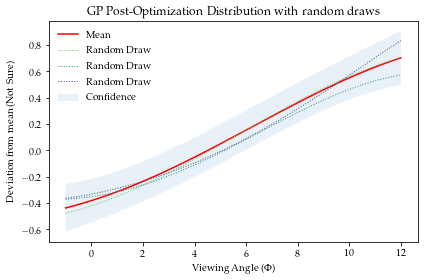

In [19]:
# predX = np.linspace(0,11,100).reshape(100, 1)
# predY = m.predict(predX)[0] - m.predict(predX)[1] # Should I be applying a random variance in pred iteratively
# # predY = med_norm_arr(predY) # Why does turning this off make a difference? 

# print(m)

# m.plot(samples = 3)
# plt.plot(predX,predY, color = "red", label = "Prediction")
# plt.ylim(-4,4)
# plt.legend()

print(m)

custom_plot(predX, before = False)

Q13) Comments about fidelity of the emulator prediction. 

In [20]:
#Q14
hist = []
vec = np.array(normed.iloc[0])
# print("Vector:",vec)

for i in range(11):
# for i in range(1):
    loo = np.delete(vec, i)
    trueY = vec[i:i+1]
    if trueY in loo:
        print("[ERROR] Element left out is in your training data")
        break 
        
        
    X = np.arange(0, gp.Nobs - 1, 1)
    Y = loo
    X = X.reshape(len(X), 1)
    Y = Y.reshape(len(Y), 1)
    kernel = GPy.kern.RBF(input_dim=1, variance = 1, lengthscale=1)
    mLoo = GPy.models.GPRegression(X, Y, kernel)
    
    mLoo.optimize #Maybe optimize researts is the correct thing to use here. 
    
    predX = np.linspace(0,10,100).reshape(100, 1)
    predY_mean, predY_var = mLoo.predict(predX)
    predY_mean = predY_mean.reshape(1, len(predY_mean))[0]
    predY_var = predY_var.reshape(1, len(predY_var))[0]
    print(predY_var) # Variances are the same? 
    hist.append((predY_mean - trueY)/np.sqrt(predY_var))

hist


[1.44892176 1.43113568 1.41794277 1.40868383 1.40258386 1.39885663
 1.39678959 1.395798   1.3954451  1.39543293 1.39557423 1.39575774
 1.39591789 1.39601503 1.39602734 1.39595075 1.39580081 1.39561131
 1.39542682 1.3952903  1.39522973 1.39524884 1.39532599 1.39542189
 1.39549387 1.39551128 1.39546638 1.39537653 1.39527692 1.39520655
 1.39519287 1.39524114 1.39533236 1.39543074 1.39549769 1.39550691
 1.3954546  1.395361   1.39526247 1.39519733 1.39519091 1.39524572
 1.3953404  1.39543809 1.39550074 1.39550395 1.39544648 1.39535071
 1.39525392 1.39519382 1.3951938  1.39525389 1.3953507  1.39544659
 1.39550429 1.39550147 1.39543942 1.39534254 1.39524883 1.39519505
 1.39520234 1.39526798 1.39536634 1.39545894 1.3955095  1.3954984
 1.39543081 1.39533546 1.3952545  1.39522822 1.39528056 1.39541039
 1.39559187 1.39578296 1.39593863 1.39602359 1.39602029 1.39593093
 1.39577562 1.39559203 1.39544247 1.3954324  1.3957399  1.39665041
 1.39858599 1.40211693 1.40794488 1.41685209 1.42961917 1.44692

[array([0.0957874842623965, 0.09580452804680838, 0.09721731854528112,
        0.09994137848940067, 0.10384378384800697, 0.10875381565022894,
        0.11447577257285446, 0.12080262475029287, 0.12752957791356143,
        0.1344668797235158, 0.14145124174975443, 0.14835516221375272,
        0.15509339611826164, 0.16162597265041412, 0.16795752435134284,
        0.1741331620626198, 0.1802315407249045, 0.18635598586325983,
        0.19262455563984532, 0.19915975857601517, 0.20607843913285345,
        0.21348218003536426, 0.22144850465041185, 0.23002319623199052,
        0.2392141454295228, 0.24898723346850882, 0.25926478920564955,
        0.2699270637270147, 0.28081691237253903, 0.29174747962793846,
        0.3025122367827274, 0.31289637245140867, 0.3226884278469986,
        0.331691264555836, 0.3397318755523363, 0.34667000083279287,
        0.35240575835761334, 0.35688641160230694, 0.36011200222540113,
        0.36213908323007127, 0.3630814734109174, 0.3631070352991583,
        0.362429997

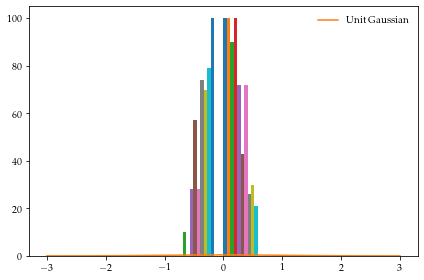

In [21]:
plt.figure()
plt.hist(hist, bins = 2)
mu = 0
sigma = 1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label = "Unit Gaussian")
plt.legend()
plt.show()